In [1]:
import pygrib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd

import datetime as dt
from dateutil.relativedelta import relativedelta

In [2]:
file_name = "adaptor.mars.internal-1622846426.3351655-26320-29-d3ec277c-a906-49aa-8941-9746ec5f867d.grib"

In [ ]:
%%time

gr = pygrib.open(file_name)

In [ ]:
%%time

gr = pygrib.open(file_name)
data_pos = []
pos = (200, 100) # Just an arbitrary position
n = 0

for g in gr:
    data_pos.append(g.values[pos])
    n += 1
print(n)

=> We have n = 508 time steps. 508 / 12 = 42.333 => The number of time steps cannot be divided by twelve. Presumably, the data from 2021 only contains the first four months.

### Visualizing the time series of a fixed position

Plot the precipitation for a fixed position. The x-axis gives the date and the y-axis gives the measured values.

In [ ]:
def plot_data_with_timestamps(x, y, ax=plt):
    """
    Use this function to show time stamps on the ticks on the x-axis.
    """
    x = pd.to_datetime(x)

    DF = pd.DataFrame()
    DF['value'] = y
    DF = DF.set_index(x)
    ax.plot(DF)
    plt.gcf().autofmt_xdate()
    
START_DATE = dt.datetime(1979, 1, 1)
n_months = 508
# The time stamps corresponding to the measured values. Consists of datetime objects.
timestamps = [START_DATE + relativedelta(months=i) for i in range(n_months)]


x = timestamps
y = data_pos
plot_data_with_timestamps(x, y)
plt.show()

The data is very noisy. Add a convolution for n = 5 time steps to smooth the data.

In [ ]:
len_conv = 5
smoothed_data = np.convolve(data_pos, np.ones(len_conv)) / len_conv 

plot_data_with_timestamps(x, smoothed_data[(len_conv - 1):])
plt.show()

Not sure if that helps a lot. But it looks a bit better I guess...


Adding vertical lines every 12 months shows the periodicity of the data: At the end of every year the precipitation is the highest (at least for the position considered).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_data_with_timestamps(x, smoothed_data[(len_conv - 1):], ax)

vert_line_pos = np.arange(len(smoothed_data) // 12 + 1) * 12
for pos in vert_line_pos:
    timestamp = timestamps[pos]
    ax.axvline(x=timestamp, ymin=0.05, ymax=.95, c='red')
plt.show()

### Animations

Next, have a look at the data as a whole. We consider the data over five years and plot it in an animation. The animation lags heavily, but can be seen as a proof of concept. When we work with only the data from west europe the animation should lag less.

In [3]:
data_five_years = np.zeros((60, 721, 1440))

gr = pygrib.open(file_name)
max_t = 60

for t, g in enumerate(gr):
    if t >= max_t:
        break
    data_five_years[t, :, :] = g.values

<IPython.core.display.Javascript object>


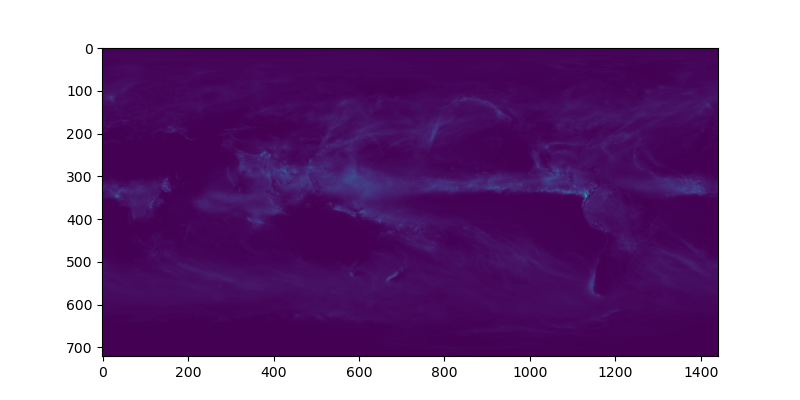

(60, 721, 1440)


In [6]:
%matplotlib notebook
def update(t, data):
    # time.sleep(0.2)
    ax.imshow(data[t])
    return None

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
ITERATIONS = data_five_years.shape[0]

anim = FuncAnimation(fig, update, frames=ITERATIONS, interval=50, blit=True, 
                     fargs=([data_five_years]))

### Questions so far:
 - The data is shaped 721 x 1440. Why 721 and not 720?
 - Which is the exact location we are looking for? What are the boundaries of "west europe"?
 - Which coordinate does the index 0, 0 refer to? (I think it is the lower left, but I am not sure)


### Findings so far:
 - The data per station seems to be periodic.
 - The resolution is 0.25° x 0.25°